### this script is trying to apply VAE to session-wise functional connectivity patterns
#### this version added subject-level as one hot encoding

In [175]:
import numpy as np
from scipy.io import loadmat
import nibabel as nib
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [176]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [177]:
from sklearn import datasets, svm
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split

In [178]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [179]:
# Load subject info
SubInfo = pd.read_excel('/Users/liuq13/NODEAP_scripts/ProcessedData/SubConds.xlsx')
Subs = SubInfo[SubInfo['Include'] == 1]['SubID']
n_subjects = len(Subs)

In [180]:
n_subjects

48

In [181]:
SubInfo.head()

,SubID,Gender,Birth.Year,StimLoc,StimOrder,Odors,StartOdor,Age,Sex,Include,btS1,btS2,btS3,btS1S2,btS2S3
0,NODEAP_06,Male,1992,Posterior,321,"Chocolate, Garlic",Sweet,30.83,M,1,1,1,1,13,15
1,NODEAP_07,Female,1991,Anterior,312,"Pineapple, Pizza",Savory,32.01,F,1,1,1,1,20,13
2,NODEAP_08,Male,1996,Posterior,132,"Chocolate, Garlic",Sweet,26.19,M,1,1,1,1,12,14
3,NODEAP_09,Female,2000,Posterior,321,"Gingerbread, Garlic",Savory,22.32,F,1,1,1,1,14,27
4,NODEAP_10,Male,1999,Posterior,321,"Chocolate, Garlic",Savory,23.62,M,1,1,1,1,13,12


In [182]:
SubInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SubID       48 non-null     object 
 1   Gender      48 non-null     object 
 2   Birth.Year  48 non-null     int64  
 3   StimLoc     48 non-null     object 
 4   StimOrder   48 non-null     int64  
 5   Odors       48 non-null     object 
 6   StartOdor   48 non-null     object 
 7   Age         48 non-null     float64
 8   Sex         48 non-null     object 
 9   Include     48 non-null     int64  
 10  btS1        48 non-null     int64  
 11  btS2        48 non-null     int64  
 12  btS3        48 non-null     int64  
 13  btS1S2      48 non-null     int64  
 14  btS2S3      48 non-null     int64  
dtypes: float64(1), int64(8), object(6)
memory usage: 5.8+ KB


In [183]:
TMS_types = []

# Loop through each row and assign TMS types based on 'StimOrder'
for i, row in SubInfo.iterrows():
    tmp_order = row['StimOrder']
    
    # Assign TMS types based on the 'StimOrder' value
    if tmp_order == 123:
        TMS_types.append(['N', 'C', 'S', 'S', 'C', 'S', 'S'])
    elif tmp_order == 132:
        TMS_types.append(['N', 'C', 'S', 'S', 'S', 'S', 'C'])
    elif tmp_order == 213:
        TMS_types.append(['N', 'S', 'C', 'C', 'S', 'S', 'S'])
    elif tmp_order == 231:
        TMS_types.append(['N', 'S', 'C', 'S', 'S', 'C', 'S'])
    elif tmp_order == 312:
        TMS_types.append(['N', 'S', 'S', 'C', 'S', 'S', 'C'])
    elif tmp_order == 321:
        TMS_types.append(['N', 'S', 'S', 'S', 'C', 'C', 'S'])

In [184]:
base_nifti_folder = '/Volumes/X9Pro/NODEAP/FuncConn_AAL_PAID'
sessions = ['D0', 'S1D1', 'S1D2', 'S2D1', 'S2D2', 'S3D1', 'S3D2']
nifti_paths_by_tms_type = {'N': [], 'C': [], 'S': []}

In [185]:
def vectorize_fc(fc_mat):
    # Upper triangle, excluding diagonal
    return fc_mat[np.triu_indices(fc_mat.shape[0], k=1)]

In [186]:
all_corr_data = []
all_tms_type = []
all_subject_id = []

for i, subject_id in enumerate(Subs):
    tms_types = TMS_types[i]  
    for j, session in enumerate(sessions):
        mat_name = 'conn_matrix_' + session + '.mat'
        mat_file = os.path.join(base_nifti_folder, subject_id, mat_name)
        if os.path.exists(mat_file):
            matdat = loadmat(mat_file)
            dat_corr = matdat['correlation_matrix']  
            dat_vec = vectorize_fc(dat_corr)  # <- vectorized
            all_corr_data.append(dat_vec)
            all_tms_type.append(tms_types[j])  # keep condition label
            all_subject_id.append(subject_id)
        else:
            print(f"matfile not found: {mat_file}")

matfile not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL_PAID/NODEAP_30/conn_matrix_S3D2.mat
matfile not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL_PAID/NODEAP_44/conn_matrix_S1D1.mat
matfile not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL_PAID/NODEAP_83/conn_matrix_S3D1.mat
matfile not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL_PAID/NODEAP_87/conn_matrix_D0.mat
matfile not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL_PAID/NODEAP_88/conn_matrix_D0.mat


In [187]:
dat_vec.shape

(14365,)

In [188]:
X = np.array(all_corr_data)  # shape: (num_sessions, 14365)
X.shape

(331, 14365)

In [189]:
label_map = {'N': 0, 'S': 1, 'C': 2}
y = np.array([label_map[t] for t in all_tms_type])
y.shape

(331,)

In [190]:
from sklearn.preprocessing import LabelEncoder

# Step 1a: convert subject strings to integers
label_encoder = LabelEncoder()
subject_ids_int = label_encoder.fit_transform(all_subject_id)  # shape (331,)
subject_ids_int.shape

(331,)

In [191]:
subject_ids_tensor = torch.tensor(subject_ids_int)
subject_ids_onehot = F.one_hot(subject_ids_tensor, num_classes=48).float()

In [192]:
subject_ids_onehot.shape

torch.Size([331, 48])

In [193]:
print("Any NaN in X?", np.isnan(X).any())

Any NaN in X? True


In [194]:
nan_cols = np.isnan(X).any(axis=0)
print(f"Columns with NaN: {nan_cols.sum()} / {X.shape[1]}")
X_clean = X[:, ~nan_cols]

print("X_clean shape:", X_clean.shape)
print("Any NaNs in X_clean?", np.isnan(X_clean).any())


Columns with NaN: 999 / 14365
X_clean shape: (331, 13366)
Any NaNs in X_clean? False


In [195]:
X = X_clean
X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)  # Standardize per feature

In [196]:
input_dim = X.shape[1]
print('input feature dimension:',input_dim)
latent_dim = 10
print('latent dimension:',latent_dim)

input feature dimension: 13366
latent dimension: 10


In [197]:
from torch.utils.data import TensorDataset, DataLoader

# convert numpy array X into a PyTorch tensor to be used in a neural network
X_tensor = torch.tensor(X, dtype=torch.float32) 
# wrap the tensor into a dataset project for easy batching
dataset = TensorDataset(X_tensor, subject_ids_tensor)
# splits data into batches and handles shuffling
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [202]:
# define VAE functions

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10, n_subjects=48):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim + n_subjects, 256) 
        self.fc2_mu = nn.Linear(256, latent_dim)
        self.fc2_logvar = nn.Linear(256, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 256)
        self.fc4 = nn.Linear(256, input_dim)

    def encode(self, x, subject_onehot):
        x_cat = torch.cat([x, subject_onehot], dim=1)
        h = F.relu(self.fc1(x_cat))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        #logvar = torch.clamp(logvar, min=-10, max=10)  # Prevent NaNs
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return self.fc4(h)

    def forward(self, x, subject_onehot):
        mu, logvar = self.encode(x, subject_onehot)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [203]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / x.size(0)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    total_loss = recon_loss + kld
    return total_loss, recon_loss, kld

In [207]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=input_dim, latent_dim=latent_dim, n_subjects=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Tracking loss over epochs
loss_history = []
recon_history = []
kld_history = []

# Training loop
for epoch in range(200):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kld = 0
    
    for batch_x, batch_subject_id in dataloader:
        batch_x = batch_x.to(device)
        batch_subject_id = batch_subject_id.to(device)
        
        # One-hot encode the subject IDs within the batch
        subject_onehot = F.one_hot(batch_subject_id, num_classes=48).float().to(device)
        
        recon, mu, logvar = model(batch_x, subject_onehot)
        loss, recon_loss, kld = vae_loss(recon, batch_x, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kld += kld.item()

    loss_history.append(total_loss)
    recon_history.append(total_recon)
    kld_history.append(total_kld)
    
    print(f"Epoch {epoch+1:03d}: Total Loss = {total_loss:.2f} | Recon = {total_recon:.2f} | KLD = {total_kld:.2f}")

Epoch 001: Total Loss = 155837.38 | Recon = 155829.41 | KLD = 7.97
Epoch 002: Total Loss = 153309.37 | Recon = 153290.85 | KLD = 18.52
Epoch 003: Total Loss = 152009.13 | Recon = 151984.99 | KLD = 24.14
Epoch 004: Total Loss = 151352.81 | Recon = 151321.14 | KLD = 31.67
Epoch 005: Total Loss = 149068.96 | Recon = 149030.71 | KLD = 38.25
Epoch 006: Total Loss = 148134.18 | Recon = 148087.44 | KLD = 46.75
Epoch 007: Total Loss = 147949.24 | Recon = 147892.40 | KLD = 56.84
Epoch 008: Total Loss = 153147.65 | Recon = 153080.46 | KLD = 67.20
Epoch 009: Total Loss = 146912.51 | Recon = 146834.10 | KLD = 78.41
Epoch 010: Total Loss = 146711.78 | Recon = 146620.17 | KLD = 91.61
Epoch 011: Total Loss = 146038.34 | Recon = 145927.51 | KLD = 110.84
Epoch 012: Total Loss = 143416.12 | Recon = 143283.80 | KLD = 132.33
Epoch 013: Total Loss = 141570.25 | Recon = 141416.31 | KLD = 153.94
Epoch 014: Total Loss = 140165.84 | Recon = 139986.37 | KLD = 179.47
Epoch 015: Total Loss = 138577.11 | Recon = 1

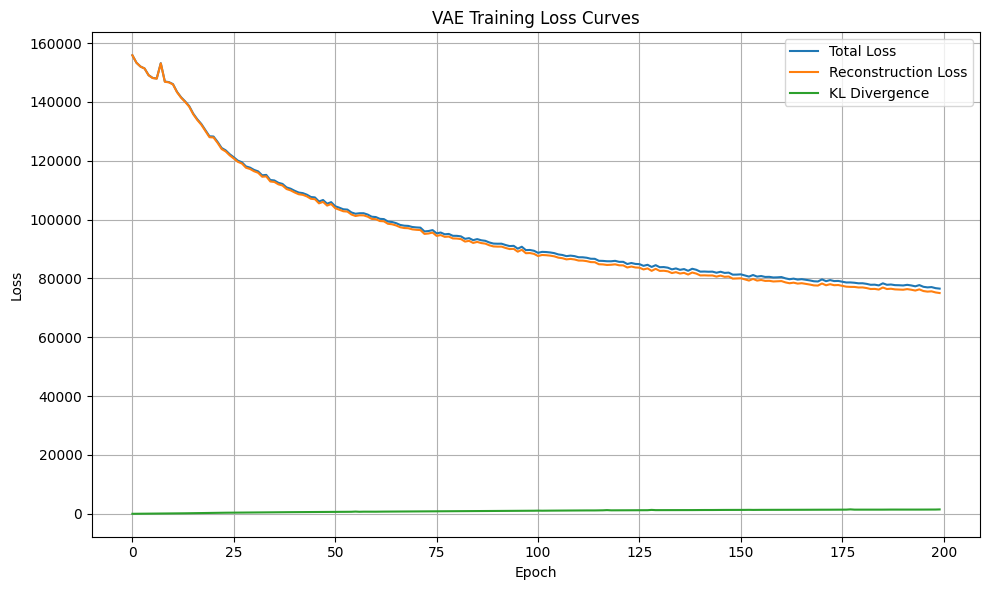

In [208]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Total Loss')
plt.plot(recon_history, label='Reconstruction Loss')
plt.plot(kld_history, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [210]:
model.eval()
with torch.no_grad():
    mu_all = []
    for i in range(X.shape[0]):
        x = torch.tensor(X[i], dtype=torch.float32).unsqueeze(0).to(device)  # shape: [1, input_dim]

        subj_id = subject_ids_int[i]  # integer from 0 to 47
        subj_onehot = F.one_hot(torch.tensor([subj_id]), num_classes=48).float().to(device)  # shape: [1, 48]

        mu, _ = model.encode(x, subj_onehot)
        mu_all.append(mu.cpu().numpy().flatten())

mu_all = np.array(mu_all)
mu_all.shape


(331, 10)

In [211]:
real_idx = (y == 2)
sham_idx = (y == 1)

mu_real = mu_all[real_idx]
mu_sham = mu_all[sham_idx]

In [212]:
# reduce to 2d using TSNE for plotting
z_2d = TSNE(n_components=2, perplexity=10).fit_transform(mu_all)
z_2d.shape

(331, 2)

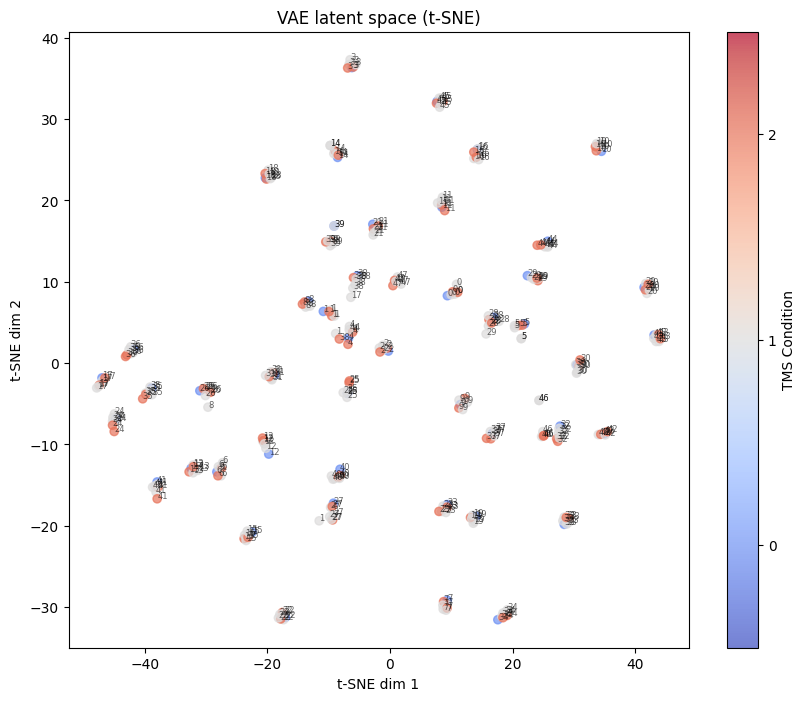

In [213]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y, cmap='coolwarm', alpha=0.7)

# Add subject ID labels
for i, sid in enumerate(subject_ids_int):
    plt.text(z_2d[i, 0], z_2d[i, 1], str(sid), fontsize=6, alpha=0.6)
    
plt.title("VAE latent space (t-SNE)")
plt.colorbar(scatter, ticks=[0, 1, 2], label='TMS Condition')
plt.clim(-0.5, 2.5)
plt.xlabel('t-SNE dim 1'); plt.ylabel('t-SNE dim 2')
plt.show()

In [214]:
df_tsne = pd.DataFrame({
    'tSNE_1': z_2d[:, 0],
    'tSNE_2': z_2d[:, 1],
    'TMS_condition': all_tms_type,
    'Subject_ID': all_subject_id
})

df_tsne.head(30)

,tSNE_1,tSNE_2,TMS_condition,Subject_ID
0,9.367203,8.293953,N,NODEAP_06
1,10.594716,8.498052,S,NODEAP_06
2,10.866089,9.700957,S,NODEAP_06
3,10.942617,8.684439,S,NODEAP_06
4,11.055099,8.717936,C,NODEAP_06
5,10.211733,8.768853,C,NODEAP_06
6,9.985385,8.415389,S,NODEAP_06
7,-10.875456,6.361269,N,NODEAP_07
8,-9.616278,6.536669,S,NODEAP_07
9,-8.863041,3.639637,S,NODEAP_07


In [57]:
clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, mu_all, y, cv=5)
print("Multiclass accuracy (Null vs Sham vs Real):", scores.mean())


Multiclass accuracy (Null vs Sham vs Real): 0.5680235187697874


In [58]:
mask_C = (y == 2)
mask_S = (y == 1)

X_bin = np.vstack([mu_all[mask_C], mu_all[mask_S]])
y_bin = np.array([1] * mask_C.sum() + [0] * mask_S.sum())

clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, X_bin, y_bin, cv=5)
print("Binary accuracy (Real vs Sham):", scores.mean())


Binary accuracy (Real vs Sham): 0.656140350877193
